In [1]:
import torch
from imagen_pytorch import Unet, Imagen, ImagenTrainer
from imagen_pytorch.data import Dataset
import random
from tqdm import tqdm
import numpy as np
import torchvision.transforms as T
from imagen_pytorch.t5 import t5_encode_text

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Python310\lib\site-packages\beartype\_util\hint\pep\utilpeptest.py:345: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.List[str] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". See this discussion for further details and alternatives:
    https://github.com/beartype/beartype#pep-585-deprecations
  warn(


In [2]:
unet = Unet(
    dim = 128, # the "Z" layer dimension, i.e. the number of filters the outputs to the first layer
    cond_dim = 128,
    dim_mults = (1, 2, 4), # the channel dimensions inside the model (multiplied by dim)
    num_resnet_blocks = 3,
    layer_attns = (False, True, True),
    layer_cross_attns = (False, True, True)
)

imagen = Imagen(
    unets = unet,
    image_sizes = 32,
    timesteps = 250,
    cond_drop_prob = 0.1,
    dynamic_thresholding=False
)


trainer = ImagenTrainer(imagen)
trainer.load("giddy-capybara.ckpt")
pass

loading saved imagen at version 1.17.1, but current package version is 1.16.5
checkpoint loaded from giddy-capybara.ckpt


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

tensor([[[[1.0000, 0.9954, 0.9983,  ..., 0.9889, 0.9900, 0.9995],
          [1.0000, 0.9890, 0.9967,  ..., 0.9946, 0.9922, 1.0000],
          [0.9974, 0.9903, 0.9983,  ..., 1.0000, 0.9998, 0.9922],
          ...,
          [0.8649, 0.8513, 0.8566,  ..., 0.6962, 0.7132, 0.7229],
          [0.8516, 0.8652, 0.8598,  ..., 0.7279, 0.7315, 0.7360],
          [0.8598, 0.8672, 0.8869,  ..., 0.7618, 0.7636, 0.7461]],

         [[1.0000, 1.0000, 0.9999,  ..., 1.0000, 0.9932, 1.0000],
          [1.0000, 0.9965, 1.0000,  ..., 0.9927, 0.9934, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9845, 0.9903, 0.9886],
          ...,
          [0.8574, 0.8630, 0.8554,  ..., 0.6927, 0.7096, 0.7203],
          [0.8561, 0.8571, 0.8566,  ..., 0.7262, 0.7346, 0.7317],
          [0.8546, 0.8594, 0.8644,  ..., 0.7539, 0.7529, 0.7291]],

         [[1.0000, 1.0000, 0.9961,  ..., 0.9992, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9957,  ..., 0

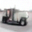

In [3]:
out = trainer.sample(["a photo of a truck"])
print(out)
img = T.ToPILImage()(out[0])
img.save("truck-4.png")
img

In [4]:
# out = imagen.sample(text_embeds=enc, text_masks=mask)
# print(out)
# img = T.ToPILImage()(out[0])
# img.save("truck-4.png")
# img

In [5]:
class ImagenOnnx(torch.nn.Module):
    def __init__(self, unet, imagen):
        super().__init__()
        
        if imagen.dynamic_thresholding == True or any(imagen.dynamic_thresholding):
            raise ValueError("no dynamic thresholding allowed, got:", imagen.dynamic_thresholding)

        self.unet = unet
        self.imagen = imagen    
            

    def sample(self, text_embeds, text_mask, cond_scale,  device, use_tqdm=True):
        batch_size = text_embeds.shape[0]
        noise_scheduler = self.imagen.noise_schedulers[0]
        img = torch.randn((batch_size, self.imagen.sample_channels[0], self.imagen.image_sizes[0], self.imagen.image_sizes[0]), device = device)        
        timesteps = noise_scheduler.get_sampling_timesteps(batch_size, device = device)
            
        
        for times, times_next in tqdm(timesteps, desc='sampling loop time step', total=len(timesteps), disable=not use_tqdm):       
            self_cond = x_start if self.unet.self_cond else None
            
            img, x_start = self.imagen.p_sample(
                self.unet,
                img,
                times,
                t_next = times_next,
                text_embeds = text_embeds,
                text_mask = text_mask,
                cond_scale = cond_scale,
                noise_scheduler = noise_scheduler,
                pred_objective = self.imagen.pred_objectives[0],
                dynamic_threshold = False
            )

        img.clamp_(-1., 1.)

        unnormalize_img = self.imagen.unnormalize_img(img)

        return unnormalize_img
    
    def forward(self, img, text_embeds, text_mask, times, times_next, cond_scale):
        return self.imagen.p_sample(
            self.unet,
            img,
            times,
            t_next = times_next,
            text_embeds = text_embeds,
            text_mask = text_mask,
            cond_scale = cond_scale,
            noise_scheduler=imagen.noise_schedulers[0],
            pred_objective = imagen.pred_objectives[0],
            dynamic_threshold = False
        )
    
u = ImagenOnnx(unet, imagen)

In [6]:
# enc, mask = t5_encode_text(["a photo of a truck"], return_attn_mask = True)
# out = u.sample(enc, mask, 1., torch.device('cuda'), use_tqdm=False)
# print(out)
# img = T.ToPILImage()(out[0])
# img.save("truck-12.png")
# img

In [27]:
out = u.forward(
    torch.rand(1, 3, 32, 32).cuda(),  
    torch.rand(1, 27, 768).cuda(), 
    torch.ones(1, 27, dtype=bool).cuda(), 
    torch.Tensor([0.9]).cuda(), 
    torch.Tensor([0.896]).cuda(), 
    torch.Tensor([1.]).cuda()
)

In [28]:
out

(tensor([[[[ 0.2748,  0.9250,  0.5351,  ...,  1.2733,  0.4265,  0.7702],
           [ 0.8397,  0.7987,  0.7799,  ..., -0.2407,  0.6717,  0.9083],
           [ 0.2817,  0.8886,  0.2003,  ...,  0.9885,  0.7546,  0.4452],
           ...,
           [-0.1932,  0.0788,  1.0260,  ...,  0.3314,  0.7054,  0.3481],
           [ 0.3075,  0.0477,  0.5602,  ...,  0.9194,  0.0665,  0.8710],
           [ 0.3930,  0.3563,  0.8796,  ...,  0.2235,  0.6368,  0.8849]],
 
          [[ 1.1616,  0.6004,  0.7262,  ...,  0.5299,  0.0334,  0.4350],
           [ 0.3489,  0.5846,  0.3296,  ...,  0.4249,  0.2732,  0.0524],
           [-0.1354,  0.2545,  0.4192,  ...,  0.3111,  0.3653,  0.8367],
           ...,
           [ 0.8770,  0.5802,  0.6854,  ...,  0.5512,  0.7838,  0.0364],
           [ 0.7926,  0.7147,  0.6851,  ..., -0.0146,  0.5998,  0.5217],
           [ 0.3273,  0.0340,  0.2636,  ...,  0.2503,  0.8422,  1.1161]],
 
          [[ 0.0133,  0.1382,  0.5957,  ...,  0.0732, -0.0968,  0.0388],
           [ 

In [11]:
ts = imagen.noise_schedulers[0].get_sampling_timesteps(1, device = device)

In [13]:
len(ts)

250

In [8]:
torch.onnx.export(
    u, 
    (
        torch.rand(1, 3, 32, 32).cuda(),  
        torch.rand(1, 27, 768).cuda(), 
        torch.ones(1, 27, dtype=bool).cuda(), 
        torch.Tensor([0.5]).cuda(), 
        torch.Tensor([0.56]).cuda(), 
        torch.Tensor([1.1]).cuda() # cond scale
    ), 
    "toymodel/public/unet-32.onnx", 
    input_names=['image', 'text_embeds', 'text_mask', 'timestep', 'time_next', 'cond_scale'], 
    output_names=['prediction', 'x_start'],
    dynamic_axes={
        'image': {0: 'batch_size'},
        'text_embeds': {0: 'batch_size', 1: 'n_tokens'},
        'text_mask': {0: 'batch_size', 1: 'n_tokens'},
    }
)

C:\Python310\lib\site-packages\imagen_pytorch\imagen_pytorch.py:2009: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert not (cond_scale != 1. and not self.can_classifier_guidance), 'imagen was not trained with conditional dropout, and thus one cannot use classifier free guidance (cond_scale anything other than 1)'
C:\Python310\lib\site-packages\einops\einops.py:204: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  inferred_length: int = length